# Should we remove the slowest nodes?

In [1]:
import io
import zipfile
import os
import pandas
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import yaml
import warnings
warnings.simplefilter(action='ignore')

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))

def get_platform(archive_name):
    info = get_yaml(archive_name, 'info.yaml')
    expfiles = info['expfile']
    platform = [f for f in expfiles if f.endswith('xml')]
    assert len(platform) == 1
    return platform[0]

def read_csv(archive_name, file_name):
    archive = zipfile.ZipFile(archive_name)
    res = pandas.read_csv(io.BytesIO(archive.read(file_name)))
    res['filename'] = archive_name
    return res

def read_result(name):
    res = read_csv(name, 'results.csv')
    res['start_timestamp'] = pandas.to_datetime(res['start_timestamp'])
    res['start'] = res['start_timestamp'] - res['start_timestamp'].min()
    return res

def read_sim_result(name):
    archive = zipfile.ZipFile(name)
    result = pandas.read_csv(io.BytesIO(archive.read('results.csv')))
    result['platform'] = get_platform(name)
    result['filename'] = name
    info = get_yaml(name, 'info.yaml')
    expfiles = info['expfile']
    dgemm_file = [f for f in expfiles if f.endswith('.yaml')]
    assert len(dgemm_file) == 1
    dgemm_model = get_yaml(name, dgemm_file[0])
    synthetic = 'experiment_date' not in dgemm_model['info']
    result['synthetic'] = synthetic
    try:
        nb_removed_nodes = dgemm_model['info']['nb_removed_nodes']
    except KeyError:
        nb_removed_nodes = 0
    result['nb_removed_nodes'] = nb_removed_nodes
    return result

simulation_dir = 'synthetic_model/2/'
simulation_files = [os.path.join(simulation_dir, f) for f in os.listdir(simulation_dir) if f.endswith('.zip')]

df = pandas.concat([read_sim_result(f) for f in simulation_files])
df['nb_nodes'] = df['proc_p'] * df['proc_q']
df['geometry'] = df['proc_p'].astype(str) + '×' + df['proc_q'].astype(str)
df.head()

,matrix_size,block_size,proc_p,proc_q,pfact,rfact,bcast,depth,swap,mem_align,...,sys_time,major_page_fault,minor_page_fault,cpu_utilization,platform,filename,synthetic,nb_removed_nodes,nb_nodes,geometry
0,300000,512,13,19,1,2,2,1,0,8,...,646.53,0,380915858,0.99,dahu_synthetic.xml,synthetic_model/2/nancy_2020-03-27_2328034.zip,True,9,247,13×19
1,500000,512,13,19,1,2,2,1,0,8,...,1807.96,0,1177095857,0.99,dahu_synthetic.xml,synthetic_model/2/nancy_2020-03-27_2328034.zip,True,9,247,13×19
2,100000,512,13,19,1,2,2,1,0,8,...,69.74,0,24926163,1.01,dahu_synthetic.xml,synthetic_model/2/nancy_2020-03-27_2328034.zip,True,9,247,13×19
3,200000,512,13,19,1,2,2,1,0,8,...,258.02,0,135071761,1.00,dahu_synthetic.xml,synthetic_model/2/nancy_2020-03-27_2328034.zip,True,9,247,13×19
4,400000,512,13,19,1,2,2,1,0,8,...,1155.70,0,726877786,0.99,dahu_synthetic.xml,synthetic_model/2/nancy_2020-03-27_2328034.zip,True,9,247,13×19


### Checking the parameters

In [2]:
name_exceptions = {'application_time', 'simulation_time', 'usr_time', 'sys_time', 'time', 'gflops', 'residual', 'cpu_utilization',
                   'dgemm_coefficient', 'dgemm_intercept', 'dtrsm_coefficient', 'dtrsm_intercept',
                   'stochastic_cpu', 'polynomial_dgemm', 'stochastic_network', 'heterogeneous_dgemm', 'platform', 'model', 'filename',
                   'simulation', 'slow_nodes',
                   'major_page_fault', 'minor_page_fault', 'matrix_size', 'mode',
                   'start_timestamp', 'stop_timestamp'}
colnames = set(df) - name_exceptions
df[list(colnames)].drop_duplicates()

,pfact,geometry,proc_p,nb_nodes,thread_per_process,swap,process_per_node,block_size,mem_align,bcast,depth,rfact,nb_removed_nodes,proc_q,synthetic
0,1,13×19,13,247,32,0,1,512,8,2,1,2,9,19,True
0,1,17×15,17,255,32,0,1,512,8,2,1,2,1,15,True
0,1,16×15,16,240,32,0,1,512,8,2,1,2,16,15,True
0,1,14×18,14,252,32,0,1,512,8,2,1,2,4,18,True
0,1,18×14,18,252,32,0,1,512,8,2,1,2,4,14,True
0,1,15×16,15,240,32,0,1,512,8,2,1,2,16,16,True
0,1,16×16,16,256,32,0,1,512,8,2,1,2,0,16,True
0,1,19×13,19,247,32,0,1,512,8,2,1,2,9,13,True
0,1,15×17,15,255,32,0,1,512,8,2,1,2,1,17,True


In [3]:
df.groupby(list(colnames))[['swap']].count()

swap
pfact geometry proc_p nb_nodes thread_per_process swap process_per_node block_size mem_align bcast depth rfact nb_removed_nodes proc_q synthetic      
1     13×19    13     247      32                 0    1                512        8         2     1     2     9                19     True         50
      14×18    14     252      32                 0    1                512        8         2     1     2     4                18     True         50
      15×16    15     240      32                 0    1                512        8         2     1     2     16               16     True         50
      15×17    15     255      32                 0    1                512        8         2     1     2     1                17     True         50
      16×15    16     240      32                 0    1                512        8         2     1     2     16               15     True         50
      16×16    16     256      32                 0    1                512        8         2     1     2     0                16     True         50
      17×15    17     255      32                 0    1                512        8         2     1     2     1                15     True         50
      18×14    18     252      32                 0    1                512        8         2     1     2     4                14     True         50
      19×13    19     247      32                 0    1                512        8         2     1     2     9                13     True         50

In [4]:
from IPython.display import display, Markdown

platforms = [(get_platform(f), zipfile.ZipFile(f).read(get_platform(f)).decode('ascii')) for f in simulation_files]
platforms = list(set(platforms))
assert(len(platforms)) == 1
for name, plat in platforms:
    display(Markdown('### %s' % name))
    display(Markdown('```xml\n%s\n```' % plat))

### dahu_synthetic.xml

```xml
<?xml version="1.0"?>
<!DOCTYPE platform SYSTEM "http://simgrid.gforge.inria.fr/simgrid/simgrid.dtd">

<platform version="4.1">
    <config id="General">
        <prop id="smpi/os" value="0:2.965491847282898e-07:9.63619592297199e-11;8133:4.117386759387727e-06:9.998650637323814e-11;15831:3.901910334928982e-06:1.1003492469181915e-10;33956:8.556208528368661e-06:1.2636592924112397e-10;64000:0.0:0.0"/>
        <prop id="smpi/or" value="0:1.3754300044375236e-06:8.456019002037162e-11;8133:1.0616877366305338e-06:1.0399801951417905e-10;15831:1.1989168715510673e-06:9.880880432093221e-11;33956:1.3028804423006338e-06:1.0742263180618875e-10;64000:0.0:0.0"/>
        <prop id="smpi/ois" value="0:6.931229521083401e-07:7.051204536228214e-11;8133:3.601990790153244e-07:1.2449128895712037e-10;15831:2.97701688103096e-06:4.1302612649640425e-11;33956:3.133466154066955e-06:3.293458765281899e-11;64000:6.939993663604069e-07:0.0"/>
        <prop id="smpi/bw-factor" value="0:0.4955575510466301;8133:5.649491428460505;15831:5.716405752533658;33956:12.659099698925065;64000:0.9867951082730274"/>
        <prop id="smpi/lat-factor" value="0:1.2162964660682605;8133:19.230103984475342;15831:18.285606440676755;33956:51.6103738900493;64000:129.24904864615127"/>
        <prop id="smpi/async-small-thresh" value="64000"/>
        <prop id="smpi/send-is-detached-thresh" value="64000"/>
        <prop id="smpi/iprobe" value="2.115437983643232e-07"/>
        <prop id="smpi/test" value="8.090518732515405e-07"/>
        <prop id="smpi/host-speed" value="1"/>
    </config>

    <AS id="AS0" routing="Full">
        <cluster id="cluster" prefix="dahu-" suffix=".grid5000.fr" radical="0-255" speed="1" bw="12.5GBps" lat="0.05us"/>
    </AS>
</platform>

```

### Checking the patch in the simulation

In [5]:
patches = set()
for row in df.iterrows():
    filename = row[1].filename
    repos = get_yaml(filename, 'info.yaml')['git_repositories']
    hpl = [repo for repo in repos if repo['path'] == 'hpl-2.2']
    assert len(hpl) == 1
    patches.add(hpl[0]['patch'])
assert len(patches) == 1
display(Markdown('```diff\n%s\n```' % patches.pop()))

```diff

diff --git a/Make.SMPI b/Make.SMPI
index c34be62..a610089 100644
--- a/Make.SMPI
+++ b/Make.SMPI
@@ -68,7 +68,7 @@ ARCH         = $(arch)
 # - HPL Directory Structure / HPL library ------------------------------
 # ----------------------------------------------------------------------
 #
-TOPdir       = /home/tom/Documents/Fac/2017_Stage_LIG/hpl-2.2
+TOPdir=/tmp/hpl-2.2
 INCdir       = $(TOPdir)/include
 BINdir       = $(TOPdir)/bin/$(ARCH)
 LIBdir       = $(TOPdir)/lib/$(ARCH)
@@ -93,9 +93,9 @@ MPlib        =
 # header files,  LAlib  is defined  to be the name of  the library to be
 # used. The variable LAdir is only used for defining LAinc and LAlib.
 #
-LAdir        = /usr/lib
+LAdir        = /tmp/lib
 LAinc        =
-LAlib        = -lblas
+LAlib        = /tmp/lib/libopenblas.so
 #
 # ----------------------------------------------------------------------
 # - F77 / C interface --------------------------------------------------
 

diff --git a/src/auxil/HPL_dlacpy.c b/src/auxil/HPL_dlacpy.c
index 70ccbce..0fd833b 100644
--- a/src/auxil/HPL_dlacpy.c
+++ b/src/auxil/HPL_dlacpy.c
@@ -342,8 +342,6 @@ void HPL_dlacpy
 /*
  * End of HPL_dlacpy
  */
-#else
-   smpi_execute_normal_size(3.871806e-09, 1.328595e-09, ((double)M)*((double)N));
 #endif // SMPI_OPTIMIZATION_LEVEL
     timestamp_t duration = get_timestamp() - start;
     record_measure("", 0, __func__, start, duration, 2, (int []){M, N});
diff --git a/src/auxil/HPL_dlatcpy.c b/src/auxil/HPL_dlatcpy.c
index 50d71eb..8bdca86 100644
--- a/src/auxil/HPL_dlatcpy.c
+++ b/src/auxil/HPL_dlatcpy.c
@@ -397,8 +397,6 @@ void HPL_dlatcpy
 /*
  * End of HPL_dlatcpy
  */
-#else
-    smpi_execute_normal_size(4.893900e-09, 4.691039e-10, ((double)M)*N);
 #endif // SMPI_OPTIMIZATION_LEVEL
     timestamp_t duration = get_timestamp() - start;
     record_measure("", 0, __func__, start, duration, 2, (int []){M, N});
diff --git a/src/pauxil/HPL_dlaswp01T.c b/src/pauxil/HPL_dlaswp01T.c
index dc0f8b3..e0d8879 100644
--- a/src/pauxil/HPL_dlaswp01T.c
+++ b/src/pauxil/HPL_dlaswp01T.c
@@ -251,8 +251,6 @@ void HPL_dlaswp01T
 /*
  * End of HPL_dlaswp01T
  */
-#else
-    smpi_execute_normal_size(7.547639e-09, 1.371708e-09, ((double)M)*((double)N));
 #endif // SMPI_OPTIMIZATION_LEVEL
     timestamp_t duration = get_timestamp() - start;
     record_measure("", 0, __func__, start, duration, 2, (int []){M, N});
diff --git a/src/pauxil/HPL_dlaswp02N.c b/src/pauxil/HPL_dlaswp02N.c
index ba461fc..d7345d9 100644
--- a/src/pauxil/HPL_dlaswp02N.c
+++ b/src/pauxil/HPL_dlaswp02N.c
@@ -204,8 +204,6 @@ void HPL_dlaswp02N
 /*
  * End of HPL_dlaswp02N
  */
-#else
-    smpi_execute_normal_size(2.822241e-08, 5.497050e-09, ((double)M)*N);
 #endif // SMPI_OPTIMIZATION_LEVEL
     timestamp_t duration = get_timestamp() - start;
     record_measure("", 0, __func__, start, duration, 2, (int []){M, N});
diff --git a/src/pauxil/HPL_dlaswp03T.c b/src/pauxil/HPL_dlaswp03T.c
index 8e54bfe..92c4665 100644
--- a/src/pauxil/HPL_dlaswp03T.c
+++ b/src/pauxil/HPL_dlaswp03T.c
@@ -185,8 +185,6 @@ void HPL_dlaswp03T
 /*
  * End of HPL_dlaswp03T
  */
-#else
-    smpi_execute_normal_size(3.775240e-09, 2.968320e-10, ((double)M)*N);
 #endif // SMPI_OPTIMIZATION_LEVEL
     timestamp_t duration = get_timestamp() - start;
     record_measure("", 0, __func__, start, duration, 2, (int []){M, N});
diff --git a/src/pauxil/HPL_dlaswp04T.c b/src/pauxil/HPL_dlaswp04T.c
index 61dd638..8e05cf3 100644
--- a/src/pauxil/HPL_dlaswp04T.c
+++ b/src/pauxil/HPL_dlaswp04T.c
@@ -269,8 +269,6 @@ void HPL_dlaswp04T
 /*
  * End of HPL_dlaswp04T
  */
-#else
-   smpi_execute_normal_size(8.498957e-09, 2.218070e-09, ((double)M1)*((double)N));
 #endif // SMPI_OPTIMIZATION_LEVEL
     timestamp_t duration = get_timestamp() - start;
     record_measure("", 0, __func__, start, duration, 3, (int []){M0, M1, N});
    

diff --git a/src/blas/HPL_dgemm.c b/src/blas/HPL_dgemm.c
index dd235b7..ab40276 100644
--- a/src/blas/HPL_dgemm.c
+++ b/src/blas/HPL_dgemm.c
@@ -204,14 +204,14 @@ double random_halfnormal_shifted(double exp, double std) {
 }

 void smpi_execute_normal(double mu, double sigma) {
-    double coefficient = random_halfnormal_shifted(mu, sigma);
+    double coefficient = mu;
     if(coefficient > 0) {
         smpi_execute_benched(coefficient);
     }
 }

 void smpi_execute_normal_size(double mu, double sigma, double size) {
-    double coefficient = random_halfnormal_shifted(mu, sigma);
+    double coefficient = mu;
     if(coefficient > 0 && size > 0) {
         smpi_execute_benched(size * coefficient);
     }
    
```

## Impact on the predicted HPL performance

In [6]:
df['n3'] = df.matrix_size ** 3
df['n2'] = df.matrix_size ** 2
df['n'] = df.matrix_size

In [7]:
from statsmodels.formula.api import ols
reg = {}
for geom in df['geometry'].unique():
    reg[geom] = ols('time ~ n3 + n2 + n', df[df['geometry'] == geom]).fit()

In [8]:
all_pred = []
for geom, r in reg.items():
    pars = r.params
    pred = pandas.DataFrame([{'n': n*10000} for n in range(1, 100)])
    pred['n2'] = pred['n']**2
    pred['n3'] = pred['n']**3
    pred['matrix_size'] = pred['n']
    pred['time'] = pars['Intercept']
    for col in ['n', 'n2', 'n3']:
        pred['time'] += pred[col]*pars[col]
    pred['gflops'] = (2/3*pred['n3'] + 2*pred['n2']) / pred['time'] * 1e-9
    pred['geometry'] = geom
    all_pred.append(pred)
pred = pandas.concat(all_pred)
pred = pred.set_index('geometry').join(df[['geometry', 'nb_nodes']].set_index('geometry')).reset_index()  # setting the number of nodes

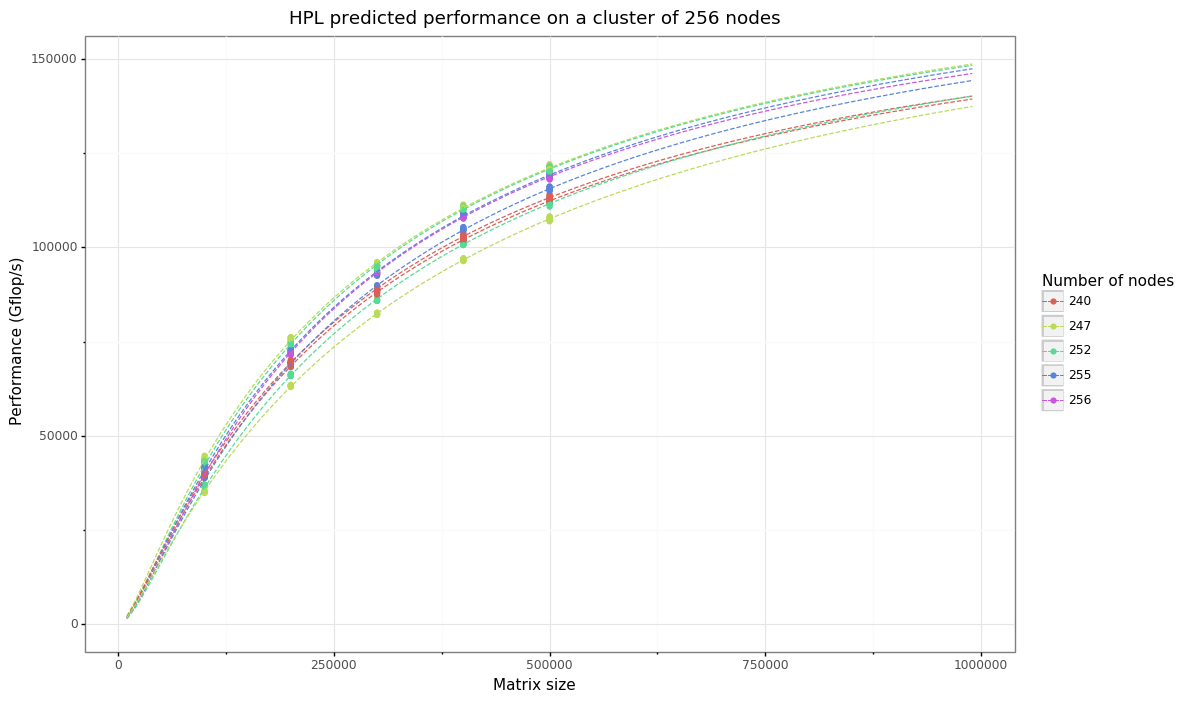

<ggplot: (8755976398063)>

In [9]:
ggplot(df) +\
    aes(x='matrix_size', group='geometry', color='factor(nb_nodes)') +\
    geom_point(aes(y='gflops')) +\
    geom_line(pred, aes(y='gflops'), linetype='dashed') +\
    xlab('Matrix size') +\
    ylab('Performance (Gflop/s)') +\
    labs(color='Number of nodes') +\
    expand_limits(y=0) +\
    ggtitle('HPL predicted performance on a cluster of 256 nodes') +\
    theme_bw()

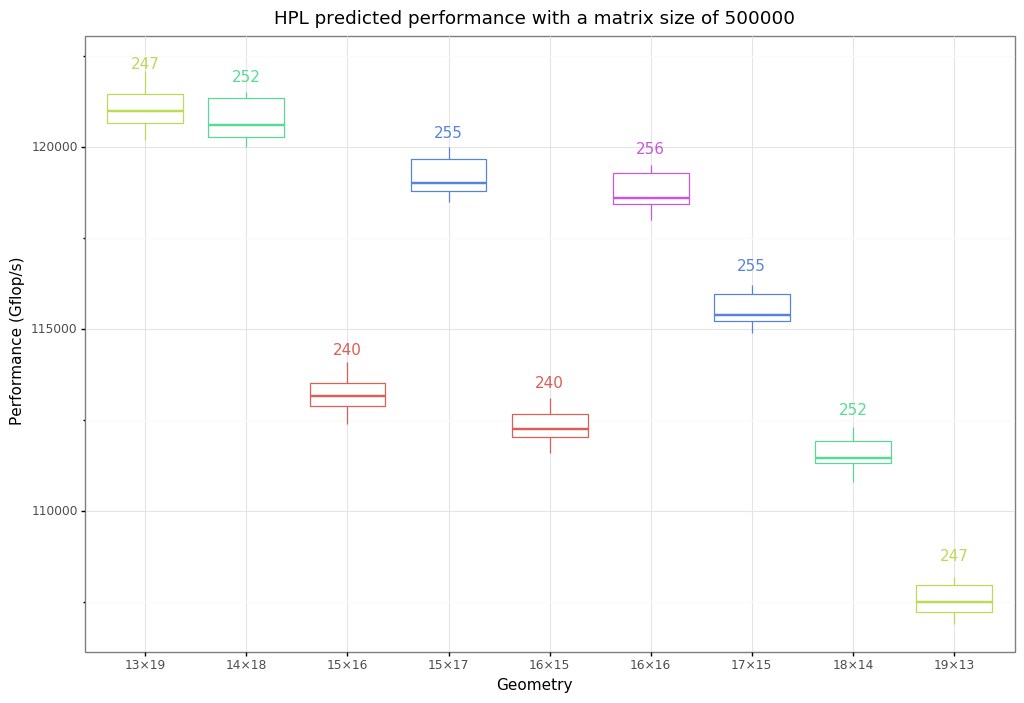

<ggplot: (8755976282344)>

In [10]:
tmp = df[df['matrix_size'] == df['matrix_size'].max()]
txt = tmp.groupby(['geometry', 'nb_nodes'])[['gflops']].mean().reset_index()
txt['txt'] = txt['nb_nodes'].astype(str)
ggplot(tmp) +\
    aes(x='factor(geometry)', y='gflops', color='factor(nb_nodes)') +\
    theme_bw() +\
    geom_boxplot() +\
    xlab('Geometry') +\
    ylab('Performance (Gflop/s)') +\
    theme(legend_position='none') +\
    ggtitle(f'HPL predicted performance with a matrix size of {df["matrix_size"].max()}') +\
    geom_text(txt, aes(label='txt'), position=position_nudge(y=1200))